<a href="https://colab.research.google.com/github/suhaani1/FitPulse-Health-Anomaly-Detection-from-Fitness-Devices/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install prophet scikit-learn matplotlib seaborn
import pandas as pd
import numpy as np

from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt


In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
from google.colab import files
uploaded = files.upload()
features = pd.read_csv(list(uploaded.keys())[0])
features

Saving tsfresh_features.csv to tsfresh_features (1).csv


,Unnamed: 0,daily_steps__has_duplicate_max,daily_steps__has_duplicate_min,daily_steps__has_duplicate,daily_steps__sum_values,daily_steps__abs_energy,daily_steps__median,daily_steps__mean,daily_steps__length,daily_steps__standard_deviation,...,resting_heart_rate__fourier_entropy__bins_3,resting_heart_rate__fourier_entropy__bins_5,resting_heart_rate__fourier_entropy__bins_10,resting_heart_rate__fourier_entropy__bins_100,resting_heart_rate__permutation_entropy__dimension_3__tau_1,resting_heart_rate__permutation_entropy__dimension_4__tau_1,resting_heart_rate__permutation_entropy__dimension_5__tau_1,resting_heart_rate__permutation_entropy__dimension_6__tau_1,resting_heart_rate__permutation_entropy__dimension_7__tau_1,resting_heart_rate__mean_n_absolute_max__number_of_maxima_7
0,3290547166,1.0,1.0,1.0,0.0,0.0,0.0,0.0,35.0,0.0,...,0.556647,0.556647,0.633663,1.241889,1.211041,1.824397,2.340741,2.744871,2.994200,81.706416
1,3656418726,1.0,1.0,1.0,0.0,0.0,0.0,0.0,29.0,0.0,...,0.485094,0.720125,0.949594,1.599015,1.486976,2.357687,2.920687,3.120292,3.135494,79.123523
2,3764646522,1.0,1.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.673012,0.673012,1.332179,1.609438,1.747868,1.791759,1.609438,1.386294,1.098612,69.551474
3,4130803406,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.693147,0.693147,0.693147,0.693147,-0.000000,2.469579,3.081540,3.282694,3.433987,79.944182
4,4217772470,1.0,1.0,1.0,0.0,0.0,0.0,0.0,29.0,0.0,...,0.627705,0.853236,1.077573,2.176186,1.686939,2.598143,2.941617,3.120292,3.135494,83.546995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,6741847857,1.0,1.0,1.0,0.0,0.0,0.0,0.0,17.0,0.0,...,0.348832,0.683739,0.683739,1.581094,1.337861,1.965237,2.138397,2.210254,2.271869,84.566318
574,6856453584,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.693147,0.693147,0.693147,0.693147,-0.000000,2.469579,3.081540,3.282694,3.433987,79.944182
575,6962181067,1.0,1.0,1.0,0.0,0.0,0.0,0.0,63.0,0.0,...,0.233792,0.414124,0.715538,1.650263,1.491608,2.334830,2.919530,3.264479,3.519913,73.273809
576,7110447015,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.693147,0.693147,0.693147,0.693147,-0.000000,2.469579,3.081540,3.282694,3.433987,79.944182


In [40]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

print("Samples:", X_scaled.shape[0])


Samples: 578


In [41]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

features["pc1"] = X_pca[:, 0]
features["pc2"] = X_pca[:, 1]


In [42]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
features["cluster"] = kmeans.fit_predict(X_pca)


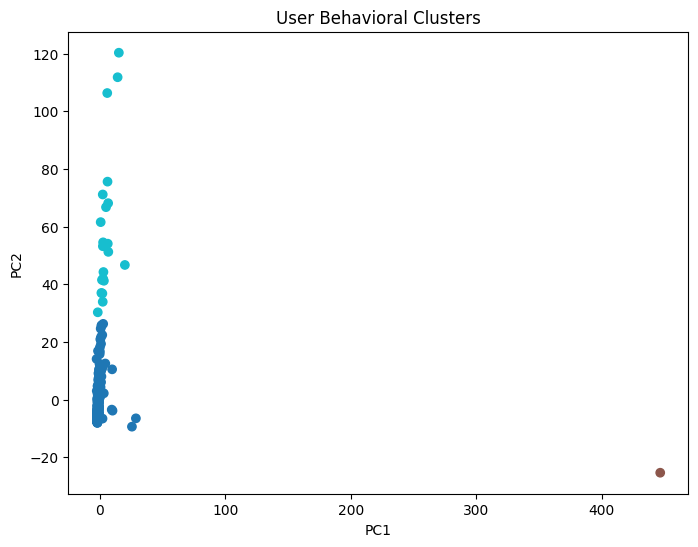

In [43]:
plt.figure(figsize=(8,6))
plt.scatter(features["pc1"], features["pc2"], c=features["cluster"], cmap="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("User Behavioral Clusters")
plt.show()


In [44]:
from google.colab import files
uploaded = files.upload()

# Example: change filename if needed
raw_df = pd.read_csv(list(uploaded.keys())[0])

raw_df.head()

raw_df["date"] = pd.to_datetime(
    raw_df["date"],
    format="mixed",
    dayfirst=True,
    errors="coerce"
)

raw_df.dropna(subset=["date"], inplace=True)


Saving clean - Copy.csv to clean - Copy (2).csv


In [45]:
from prophet import Prophet
import pandas as pd

def predict_metric(raw_df, metric):
    df = raw_df[["date", metric]].copy()

    # Prophet-required column names
    df.columns = ["ds", "y"]

    # ✅ REMOVE TIMEZONE (FIX)
    df["ds"] = pd.to_datetime(df["ds"]).dt.tz_localize(None)

    # Drop missing values
    df.dropna(inplace=True)

    # Fit model
    model = Prophet()
    model.fit(df)

    # Forecast
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    return model, forecast


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


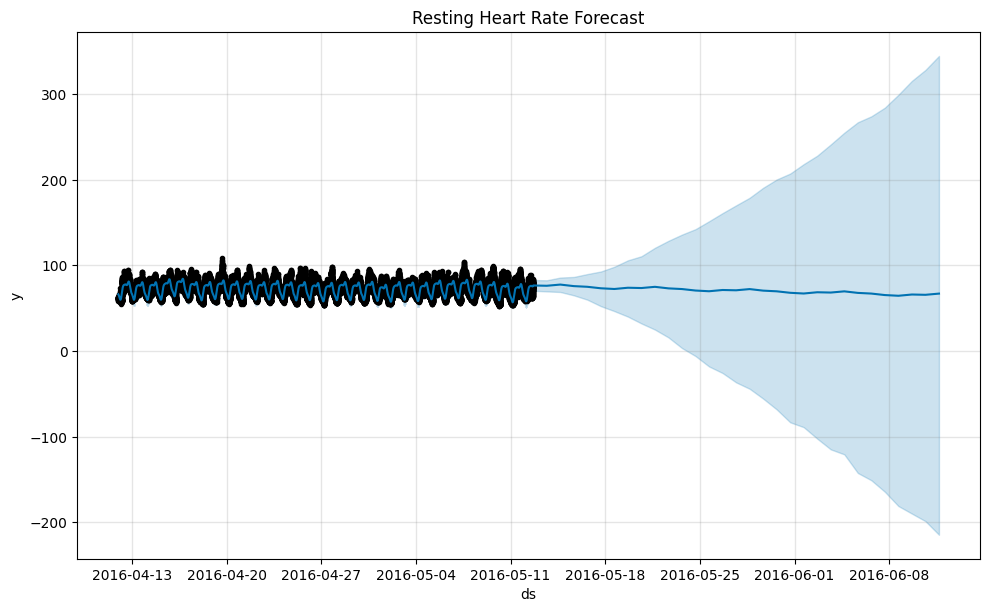

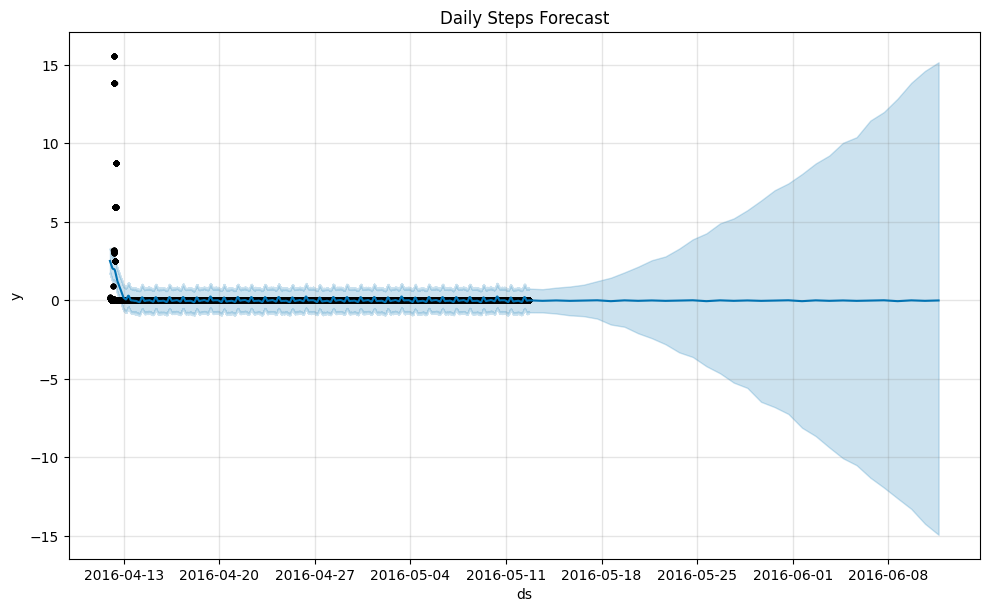

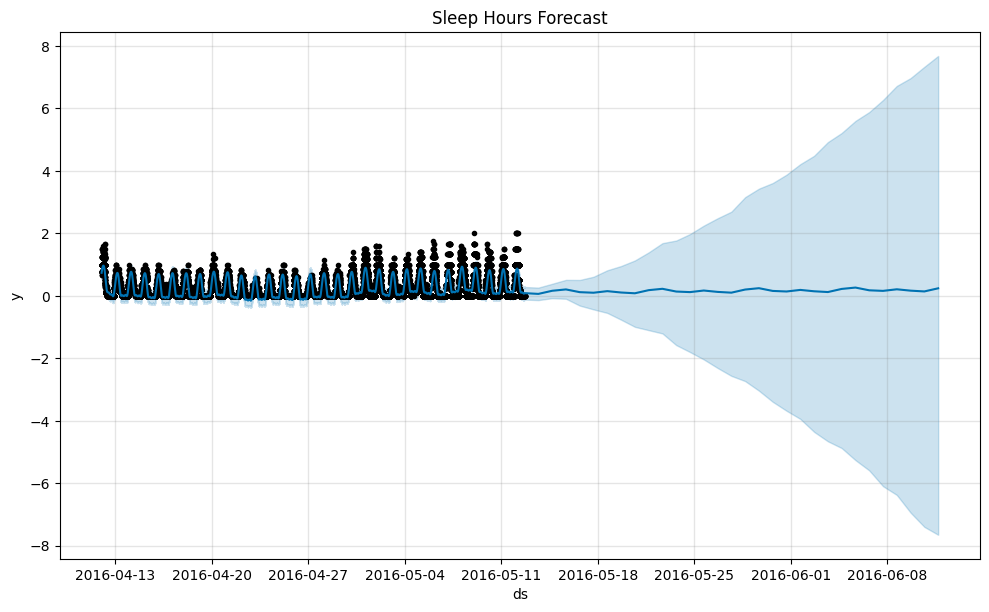

In [46]:
hr_model, hr_forecast = predict_metric(raw_df, "resting_heart_rate")
steps_model, steps_forecast = predict_metric(raw_df, "daily_steps")
sleep_model, sleep_forecast = predict_metric(raw_df, "hours_sleep")

# Plot individually
hr_model.plot(hr_forecast)
plt.title("Resting Heart Rate Forecast")
plt.show()

steps_model.plot(steps_forecast)
plt.title("Daily Steps Forecast")
plt.show()

sleep_model.plot(sleep_forecast)
plt.title("Sleep Hours Forecast")
plt.show()



In [47]:
from prophet import Prophet
import pandas as pd

def prophet_model(df, metric, periods=30):
    data = df[["date", metric]].copy()

    # Rename for Prophet
    data.columns = ["ds", "y"]

    # ✅ REMOVE TIMEZONE (CRITICAL FIX)
    data["ds"] = pd.to_datetime(
        data["ds"],
        format="mixed",
        dayfirst=True,
        errors="coerce"
    ).dt.tz_localize(None)

    # Clean data
    data.dropna(inplace=True)

    # Safety check
    if data.shape[0] < 10:
        raise ValueError(f"Not enough data points for Prophet on {metric}")

    # Fit Prophet
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )
    model.fit(data)

    # Forecast
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    return forecast


In [48]:
hr_forecast = prophet_model(df, "resting_heart_rate")
steps_forecast = prophet_model(df, "daily_steps")
sleep_forecast = prophet_model(df, "hours_sleep")


In [49]:
df["expected_hr"] = hr_forecast["yhat"][:len(df)].values
df["hr_residual"] = df["resting_heart_rate"] - df["expected_hr"]

df[["resting_heart_rate", "expected_hr", "hr_residual"]].head()


,resting_heart_rate,expected_hr,hr_residual
0,60.812500,69.080706,-8.268206
1,61.694927,69.084866,-7.389939
2,62.183333,69.089023,-6.905690
3,61.358334,69.093177,-7.734843
4,61.400000,69.097328,-7.697328


In [50]:
# The variable 'selected_features' was not defined.
# Using the already existing 'X_scaled' (scaled features before PCA) for clustering.
# The scaling step is removed as 'X_scaled' is already prepared.

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the 'features' DataFrame
features["cluster"] = clusters
features.head()

,Unnamed: 0,daily_steps__has_duplicate_max,daily_steps__has_duplicate_min,daily_steps__has_duplicate,daily_steps__sum_values,daily_steps__abs_energy,daily_steps__median,daily_steps__mean,daily_steps__length,daily_steps__standard_deviation,...,resting_heart_rate__fourier_entropy__bins_100,resting_heart_rate__permutation_entropy__dimension_3__tau_1,resting_heart_rate__permutation_entropy__dimension_4__tau_1,resting_heart_rate__permutation_entropy__dimension_5__tau_1,resting_heart_rate__permutation_entropy__dimension_6__tau_1,resting_heart_rate__permutation_entropy__dimension_7__tau_1,resting_heart_rate__mean_n_absolute_max__number_of_maxima_7,pc1,pc2,cluster
0,3290547166,1.0,1.0,1.0,0.0,0.0,0.0,0.0,35.0,0.0,...,1.241889,1.211041,1.824397,2.340741,2.744871,2.994200,81.706416,-1.180913,-3.725887,0
1,3656418726,1.0,1.0,1.0,0.0,0.0,0.0,0.0,29.0,0.0,...,1.599015,1.486976,2.357687,2.920687,3.120292,3.135494,79.123523,-1.180766,-3.780490,0
2,3764646522,1.0,1.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,...,1.609438,1.747868,1.791759,1.609438,1.386294,1.098612,69.551474,-1.602595,-5.294948,0
3,4130803406,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.693147,-0.000000,2.469579,3.081540,3.282694,3.433987,79.944182,-1.687430,-6.056903,0
4,4217772470,1.0,1.0,1.0,0.0,0.0,0.0,0.0,29.0,0.0,...,2.176186,1.686939,2.598143,2.941617,3.120292,3.135494,83.546995,-1.293316,-2.510047,0


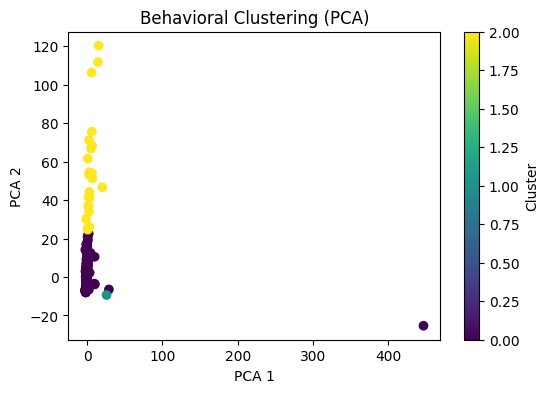

In [51]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="viridis")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Behavioral Clustering (PCA)")
plt.colorbar(label="Cluster")
plt.show()


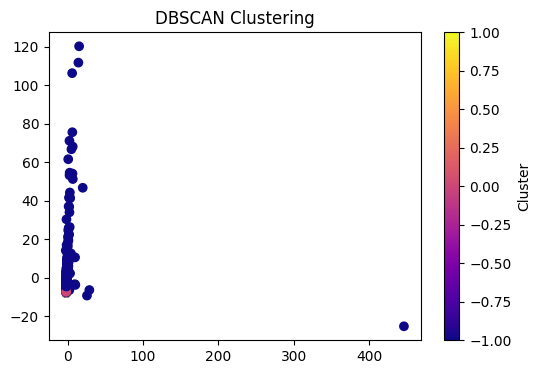

In [52]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=dbscan_labels, cmap="plasma")
plt.title("DBSCAN Clustering")
plt.colorbar(label="Cluster")
plt.show()
